# Hoja de Trabajo 1 
## Elements of Machine Learning 
### José Alejandro Guzmán Zamora 


### Procesamiento y Exploración Inicial
En las siguientes celdas se lleva a cabo la carga de datos y el pre-procesamiento, por favor leer los comentarios para detalles específicos de conjuntos de líneas de código

In [6]:
# Importar las librerías que voy a utilizar 
from sklearn import preprocessing
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import gradiente as gd
from sklearn.model_selection import train_test_split

# Configuraciones para mostrar todos los datos en pantalla
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Configuración para mostrar gráficas en el mismo notebook 
%matplotlib inline

In [7]:
# Lectura inicial de cada uno de los datasets 
data_primero = pd.read_csv('./losangeles.csv')
data_segundo = pd.read_csv('./newyork.csv')

# Concatenarlos para obtener el dataset principal a utilizar 
data_primero = pd.concat([data_primero, data_segundo])

# Inicio de la exploración básica 
data_primero.head()

,Commodity Name,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,Mostly High,Origin,Origin District,Item Size,Color,Environment,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode
0,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/24/2016,120.0,130.0,120.0,130.0,CALIFORNIA,NaN,lge,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,09/24/2016,120.0,130.0,120.0,130.0,CALIFORNIA,NaN,med,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/01/2016,120.0,130.0,120.0,130.0,CALIFORNIA,NaN,lge,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/01/2016,120.0,130.0,120.0,130.0,CALIFORNIA,NaN,med,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,PUMPKINS,LOS ANGELES,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,10/08/2016,120.0,130.0,120.0,130.0,CALIFORNIA,NaN,lge,NaN,NaN,PER BIN,NaN,NaN,NaN,NaN,NaN,N,NaN


In [8]:
# El precio va a depender del tipo de paquete, esto significa que los precios originales 
# no están estandarizados, por lo que hay que indagar un poco más en el dato 
tipos_paquetes = data_primero.Package.unique()
print("Tipos de paquetes:\n",tipos_paquetes)

Tipos de paquetes:
 ['24 inch bins' '36 inch bins' 'bins' '35 lb cartons' 'each'
 '1 1/9 bushel cartons' 'bushel cartons' '1/2 bushel cartons'
 '1 1/9 bushel crates']


In [10]:
# Hay que separar el dataset en los distintos tipos y normalizar por separado antes de volver a juntarlos 
# En el siguiente arreglo se obtiene cada subdataset por tipo de paquete 
separados = [data_primero[data_primero.Package == i] for i in tipos_paquetes]

In [11]:
# Normalizacion de los datasets 

# En el siguiente loop se normaliza cada uno de los datasets y se agrega a un arreglo 
total = []
for i in separados:
    arreglo = np.array(i['High Price'])
    normalizado = preprocessing.normalize([arreglo]).transpose()
    normalf = pd.DataFrame(normalizado, index=i.index)
    total.append(normalf)

# Finalmente, se hace concat y se obtiene un dataset con todos los precios normalizados por separado 
total = pd.concat(total, join='outer')

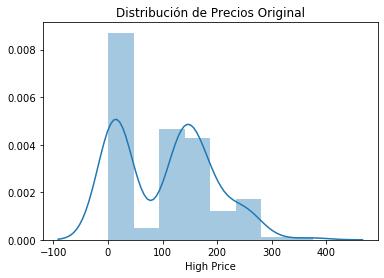

In [18]:
# Distribución Inicial de los precios altos 
sns.distplot(data_primero['High Price']).set_title("Distribución de Precios Original")
plt.show()
# Al momento que se muestre la gráfica, se puede verificar que la distribución 
# no es del todo normal, tiene dos picos de similar tamaño y cierto sesgo a la derecha

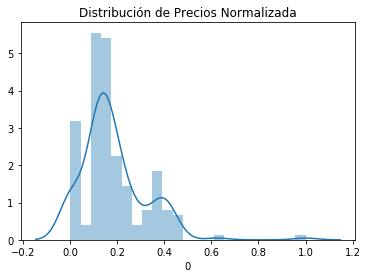

In [21]:
# Distribución a utilizar con los precios normalizados por separado
ax = sns.distplot(total[0]).set_title("Distribución de Precios Normalizada")
plt.show()

# Al momento que se muestre la gráfica se puede visualizar una distribución 
# relativamente más normal y el sesgo ya es evidente

In [29]:
# A continuación se hace una verificación de datos nulos 

# Utilizar el nombre de data para la continuación, obtiene solo las columnas que nos interesan 
data = total.copy()
tama = data_primero['Item Size'].to_frame()
tama.reset_index(inplace=True)
data.reset_index(inplace=True)
data = pd.concat([data, tama], axis=1)[[0, 'Item Size']]

In [30]:
# Eliminación de todas las observaciones con datos nulos

proporcion = np.round(data.isna().sum().sum() / data.shape[0], 3)
print("Proporción de datos nulos: ", proporcion)
data.dropna(inplace=True)
print("Datos nulo eliminados")

Proporción de datos nulos:  0.138
Datos nulo eliminados


### Preparación de Datos para los entrenamientos 
La data en la columna de Item Size es categórica, el algoritmo que se utiliza en este caso solo permite data numérica, por lo que en las siguientes celdas se hace lo necesario para que funcione.

In [32]:
# Verificar los tipos de categorias, se puede ver que son ordinales 
tipos_tam = data_primero['Item Size'].unique()
print("Tipos de Tamaño: \n",tipos_tam)

# Al ser ordinales no es necesario hacer one hot encoding, se pueden 
# codificar con números de 1 hasta k dónde k es la cantidad de 
# categorías

Tipos de Tamaño: 
 ['lge' 'med' 'med-lge' 'sml' nan 'xlge' 'exjbo']


In [33]:
# Reemplazo de valores categóricas por su número respectivo

data_segundo = data_primero.copy()
tama = ['sml', 'med', 'med-lge', 'lge', 'xlge', 'exjbo']
for i in range(1,7):
    mascara = data_segundo['Item Size'] == tama[i - 1]
    data_segundo.loc[mascara, 'Item Size'] = i

In [37]:
# Se va a continuar trabajando sobre data_usar, se obtienen 
# las columnas necesarias 

data_p = total.copy()
sizes = data_segundo['Item Size'].to_frame()
data_p.reset_index(inplace=True)
sizes.reset_index(inplace=True)
data_usar = pd.concat([data_p, sizes], axis=1)[[0,'Item Size']]
data_usar.dropna(inplace=True)

In [38]:
data_usar.head()

,0,Item Size
0,0.148419,4
1,0.148419,2
2,0.148419,4
3,0.148419,2
4,0.148419,4


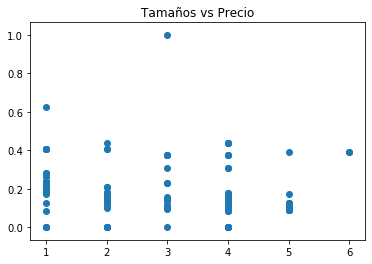

In [42]:
# Visualización de relación entre los tamaños y el precio de 
# las calabazas 
plt.scatter(data_usar['Item Size'], data_usar[0])
plt.title("Tamaños vs Precio")
plt.show()

### Modelado y Cross Validation
En las siguientes celdas se obtienen distintos modelos y se escoge uno en base a los resultados del cross validation.

In [43]:
# Preparación de columa de 0s que hace que el algoritmo funcione correctamente 

m,_ = data_usar.shape

x = data_usar['Item Size'].to_numpy().reshape(m,1)
ys = data_usar[0].to_numpy().reshape(m, 1)
xs = np.asarray(np.hstack((np.ones(m).reshape(m,1), x)), dtype='float64')

In [45]:
# Funciones Principales 
# Estas funciones llaman al algoritmo de gradient_descent
# El cross validation que se estará utilizando es de 80% para entrenamiento 
# y el 20% para pruebas 

def test_model(xs, ys, thetas, alpha, it):
    X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.20, random_state=42)
    calc = gd.gradient_descent(X_train, y_train, thetas, alpha, it, 0.0000001)
    print("Resultado Modelo, la hipotesis a la que se llego es la siguiente: ")
    print(calc[1][len(calc[1]) - 1])
    print("El costo con el test es el siguiente: ")
    test_cost = gd.cost(X_test, y_test, calc[0])
    print(np.round(test_cost, 6))
    return calc[0]

def graph_model(resultado, data, k):
    plt.scatter(data['Item Size'],data[0])
    x = np.linspace(0,10,data.shape[0])
    y = resultado[0]
    for i in range(1, k + 1):
        y = y + resultado[i] * (x ** i)
    plt.plot(x,y,'-r')
    plt.show()

56
Resultado Modelo, la hipotesis a la que se llego es la siguiente: 
H(56) =[[0.00813207]
 [0.0217096 ]] costo -> 0.0177
El costo con el test es el siguiente: 
0.010041


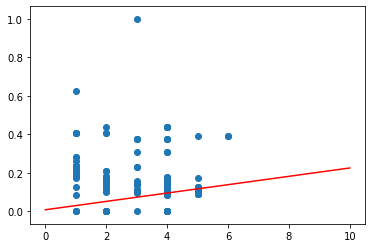

In [48]:
# Primera prueba, complejidad 1 
resultado = test_model(xs, ys, [0,0], 0.001, 1000)
graph_model(resultado, data_usar, 1)

En la prueba anterior se obtiene un error de entrenamiento de : 0.017
y un error de prueba de : 0.010

El algoritmo tuvo que realizar 56 iteraciones para salir y el costo al que se llegó 
es bastante bueno relativo a la nube de puntos 

39
Resultado Modelo, la hipotesis a la que se llego es la siguiente: 
H(39) =[[0.02388977]
 [0.02832388]
 [0.0004376 ]] costo -> 0.0148
El costo con el test es el siguiente: 
0.008568


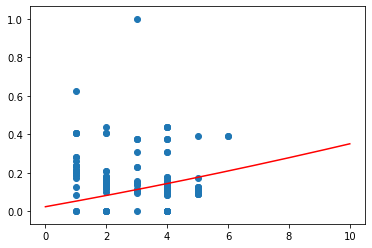

In [49]:
# Ahora vamos a aumentar el grado del polinomio a 2 
siguiente = (xs[:,1] ** 2).reshape(xs.shape[0],1)
xs2 = np.hstack((xs, siguiente))
resultado2 = test_model(xs2, ys, [0,0,0], 0.009, 1000)
graph_model(resultado2, data_usar, 2)

Se puede ver que en esta prueba el algoritmo solo tuvo que hacer 39 iteraciones 
para salir. Resultó con un error de entrenamiento de : 0.014 y un error de prueba
de : 0.0085. Este modelo tiene mejores resultados que el anterior, hay que verificar
si al seguir aumentando se obtiene todavía menor error. 

4
Resultado Modelo, la hipotesis a la que se llego es la siguiente: 
H(4) =[[6.15819854e-05]
 [1.45548541e-04]
 [4.37592081e-04]
 [1.55070705e-03]] costo -> 0.0204
El costo con el test es el siguiente: 
0.012682


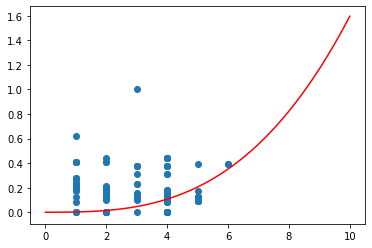

In [50]:
# Ahora vamos a aumentar el grado del polinomio a 3 
siguiente3 = (xs[:,1] ** 3).reshape(xs.shape[0],1)
xs3 = np.hstack((xs2, siguiente3))
resultado3 = test_model(xs3, ys, [0,0,0,0], 0.00009, 1000)
graph_model(resultado3, data_usar, 3)

En este caso el costo de entrenamiento fue de : 0.20 y el de prueba fue 
de : 0.013. Los resultados no son muy buenos en comparación al anterior,  
pareciera que el modelo está perdiendo su generalidad. Para comprobarlo, 
se va a realizar una prueba más.

1
Resultado Modelo, la hipotesis a la que se llego es la siguiente: 
H(1) =[[2.67007442e-06]
 [6.60876873e-06]
 [2.07046678e-05]
 [7.56144790e-05]
 [3.05702015e-04]] costo -> 0.0216
El costo con el test es el siguiente: 
0.013401


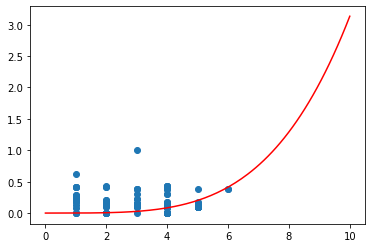

In [51]:
# Ahora vamos a aumentar el grado del polinomio a 4
siguiente4 = (xs[:,1] ** 4).reshape(xs.shape[0],1)
xs4 = np.hstack((xs3, siguiente4))
resultado4 = test_model(xs4, ys, [0,0,0,0,0], 0.000009, 10000)
graph_model(resultado4, data_usar, 4)

En este caso todavía más específico el error de entrenamiento fue de :
0.021 y el error de pruebas fue de : 0.13. Es decir, todavía tiene 
menor rendimiento que el modelo anterior a pesar de ser más expresivo.

## Análisis Final 

En base a lo que se observó al momento de hacer las pruebas con diferentes complejidades de modelos, hay suficiente información para determinar que el modelo polinómico que se ajusta de mejor manera a los datos es el de segundo grado, este modelo obtuvo un error de entrenamiento de 0.0148 y un error de pruebas de 0.008568. El modelo que se obtuvo se puede describir mediante los siguientes valores theta:
theta1 = 0.02388977<br/>
theta2 = 0.02832388<br/>
theta3 = 0.0004376 <br/>

El modelo de complejidad 1 obtuvo buenos resultados pero estuvieron debajo del modelo seleccionado. Por el otro lado, los modelos de complejidades mayores se volvieron más específicos pero el error de pruebas empezó a aumentar conforme aumentaba la complejidad. <br/>
Un detalle que vale la pena hacer notar es que mientras aumentaron las complejidades, disminuyó la cantidad de iteraciones que el algoritmo tenía que hacer para salir. Esto podría explicarse por la expresividad de cada modelo y su relación con los datos. Sin embargo, hay que recordar que en todos los casos se inicializaron los thetas con 0, esto se hizo porque al inicializarlos con valores aleatoreos se llegaba a un modelo con costos mucho mayores. 

En cuanto a los datos, se puede concluir que mientras aumenta el tamaño de las calabazas, generalmente va a aumentar el precio.